In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import os

plt.style.use(["science", "ieee", "no-latex"])
plt.rcParams["font.size"] = 7
plt.rcParams["axes.labelsize"] = 7


def format(mirror: str) -> int:

    m, n = mirror[:2], int(mirror[2:])

    if m == "ll":
        n += 0
    if m == "lm":
        n += 7
    if m == "la":
        n += 14
    if m == "co":
        n += 21
    if m == "he":
        n += 28

    return n

/tmp/ipykernel_2296982/2864216274.py:112: RuntimeWarning: divide by zero encountered in divide
  data.append(cal_xy / cal_std)
/tmp/ipykernel_2296982/2864216274.py:113: RuntimeWarning: divide by zero encountered in divide
  data_corr.append(cal_xy_corr / cal_std)


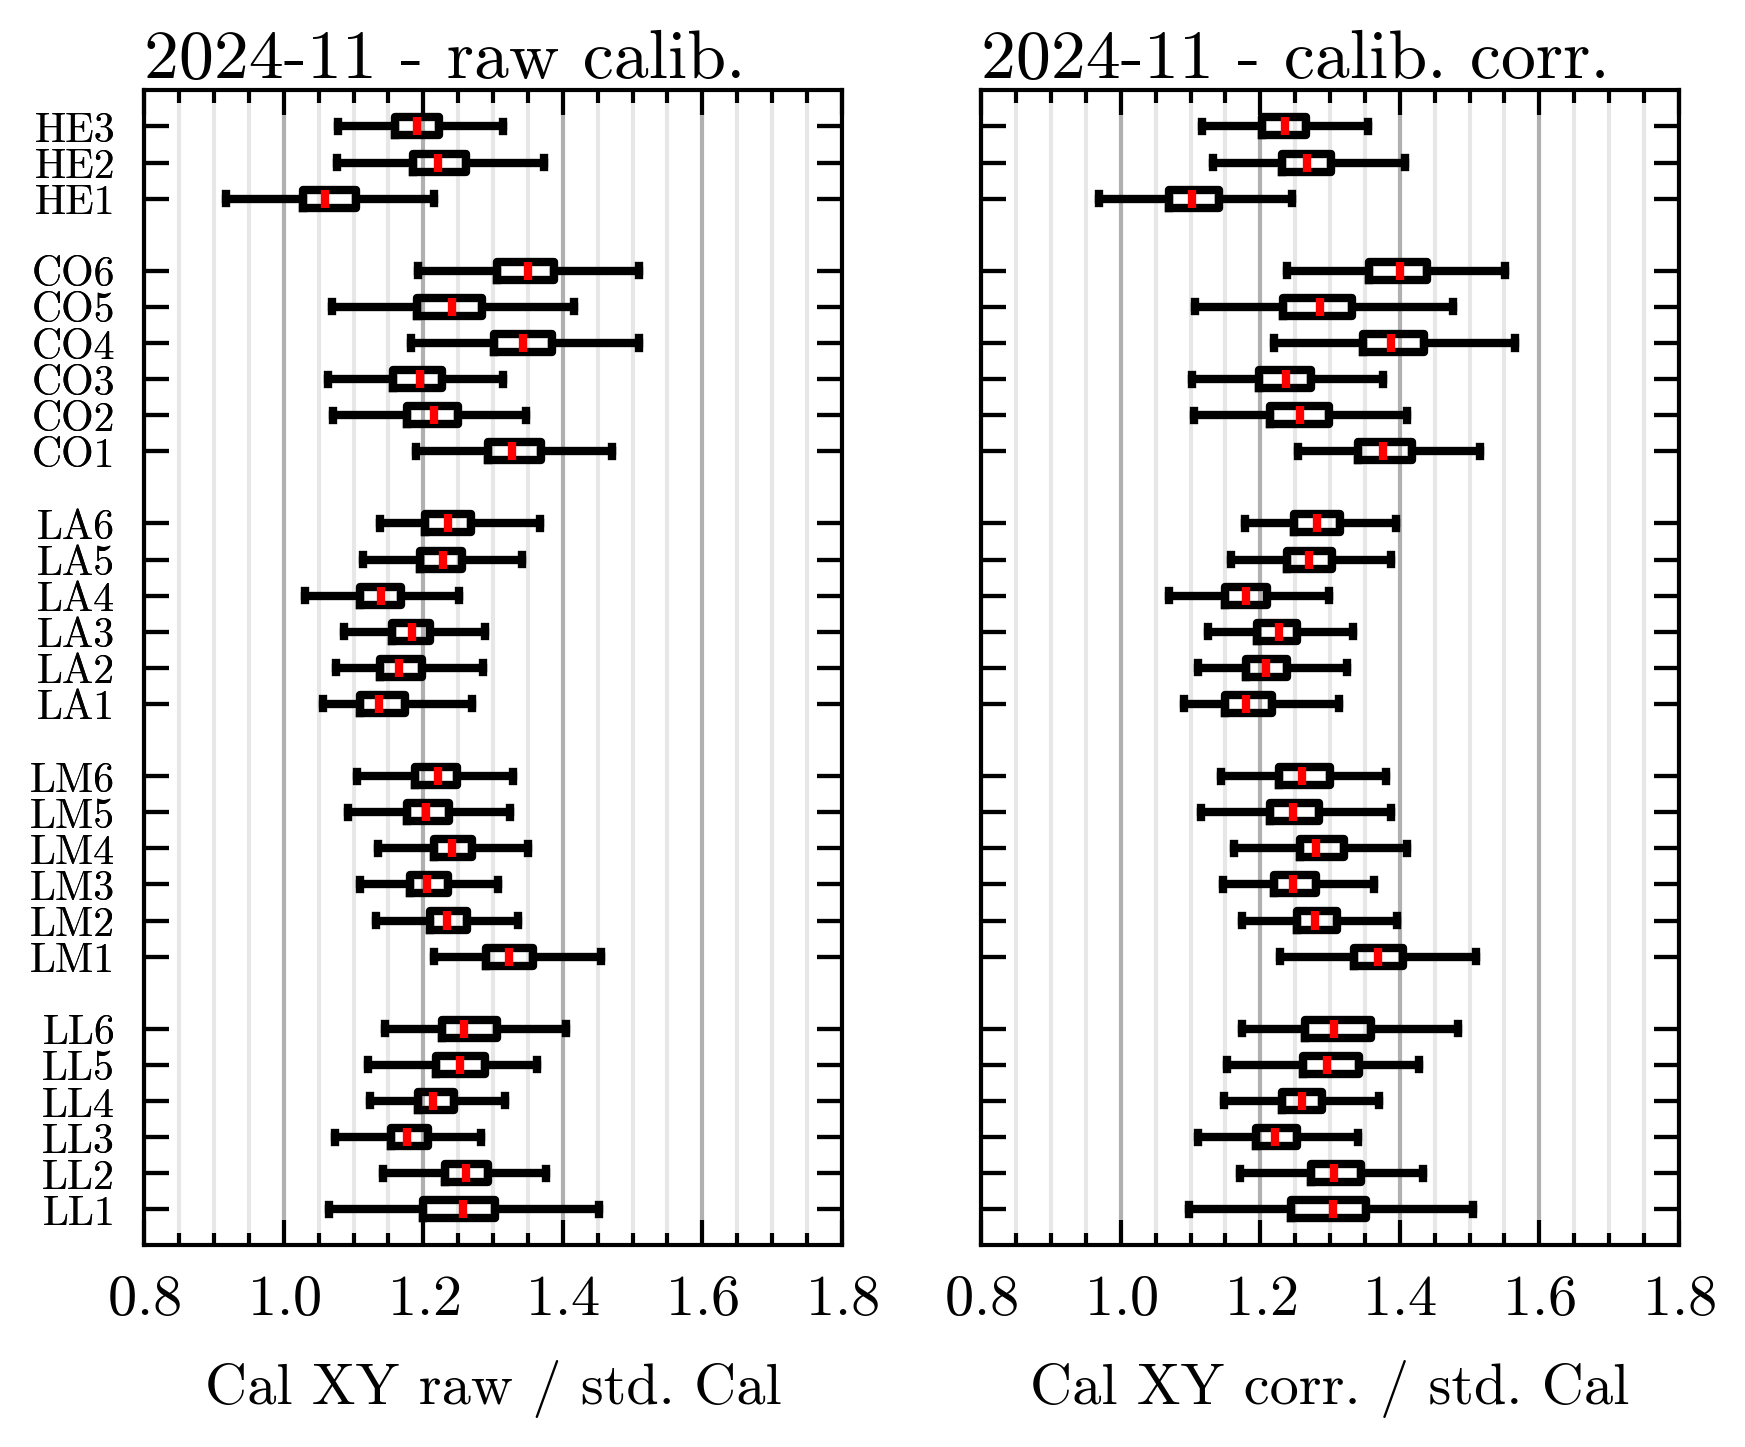

In [10]:
runlist_dir = "/cr/data01/filip/xy-calibration/config/calib_runlists/"
source_dir = "/cr/data01/filip/xy-calibration/results/"

reject = [
    "" "15952x",  # co2 due to ??? (ASK!!!!!!!!!!)
    "15920x",  # co5 due to curtain in aperture
    "6075",  # he2 due to cold electronics
]

# fig, axes = plt.subplots(4, 1, sharex=True)

figs_and_axes = [plt.subplots(1, 2, sharey=True) for _ in range(5)]
figs, axes = [a[0] for a in figs_and_axes], [a[1] for a in figs_and_axes]

for (ax1, ax2), list, fig in zip(
    axes, ["2019-11", "2022-10", "2023-10", "2023-11", "2024-11"], figs
):

    if list != "2024-11": 
        plt.close(fig)
        continue

    ax1.set_yticks([], minor=True)
    ax1.set_yticklabels([], fontsize=5)
    ax1.set_xticks(np.arange(0.8, 1.8, 0.05), minor=True)  # set minor ticks on x-axis
    ax2.set_xticks(np.arange(0.8, 1.8, 0.05), minor=True)  # set minor ticks on x-axis
    ax1.set_xticks(np.arange(0.8, 1.9, 0.2))
    ax2.set_xticks(np.arange(0.8, 1.9, 0.2))
    ax1.set_ylim(0, 32)

    ax1.text(
        0,
        1,
        f"{list} - raw calib.",
        transform=ax1.transAxes,
        ha="left",
        va="bottom",
        fontsize="large",
        fontweight="bold",
    )
    ax2.text(
        0,
        1,
        f"{list} - calib. corr.",
        transform=ax2.transAxes,
        ha="left",
        va="bottom",
        fontsize="large",
        fontweight="bold",
    )
    ax1.set_xlabel(r"Cal XY raw / std. Cal")
    ax2.set_xlabel(r"Cal XY corr. / std. Cal")
    ax1.set_xlim(0.8, 1.8)
    ax2.set_xlim(0.8, 1.8)
    ax1.grid(axis="x")
    ax2.grid(axis="x")
    ax1.grid(axis="x", which="minor", alpha=0.3)
    ax2.grid(axis="x", which="minor", alpha=0.3)

    with open(f"{runlist_dir}calib_runs_{list}.list", "r") as f:
        header = f.readline().strip().split(";")

    df = pd.read_csv(
        f"{runlist_dir}/calib_runs_{list}.list",
        comment="#",
        delimiter=";",
        names=header,
    )

    pos, label, data, data_corr = [], [], [], []

    for i, run in df.iterrows():
        if run["#runid"].strip() in reject:
            continue
        if not run["forDB"]:
            continue
        if not run["source"].strip() in ['"OLO"', "OLO"]:
            continue
        if not run["comment"].strip() != "":
            continue

        try:

            cal_xy, cal_std, cal_xy_corr = np.loadtxt(
                f'{source_dir}/outCorr_{run["#runid"]}.txt',
                usecols=[1, 3, 4],
                unpack=True,
            )
            # if run['#runid'] in ['12806', '12809']:
            #     cal_std = np.loadtxt(f'{runlist_dir}/../../save_{run["#runid"].strip()}.txt', usecols=[3])

            if os.path.isfile(
                pixel_mask_file := f'{runlist_dir}/../pixel_masks/{run["telescope"].strip()}.txt'
            ):
                pixel_mask = np.loadtxt(pixel_mask_file, usecols=[-1], dtype=bool)
            else:
                pixel_mask = np.ones(440, dtype=bool)

            cal_xy[~pixel_mask] = np.nan
            cal_xy_corr[~pixel_mask] = np.nan

            pos.append(format(run["telescope"].strip()))
            label.append(run["telescope"].strip().upper())

            if label[-1] == "LL1":
                data.append(ll1_raw)
                data_corr.append(ll1_corr)
            elif label[-1] == 'LL6':
                data.append(ll6_raw)
                data_corr.append(ll6_corr)
            else:
                data.append(cal_xy / cal_std)
                data_corr.append(cal_xy_corr / cal_std)

            # os.system(f'mkdir -p /home/filip/Desktop/pixel_constants/{list}/')
            # np.savetxt(f'/home/filip/Desktop/pixel_constants/{list}/{run["telescope"].strip()}',
            #            np.column_stack([np.arange(1, 441, 1), data[-1], data_corr[-1]]), fmt='%s')

        except FileNotFoundError:
            continue

    # pixel calibConst adcSum stdCalib calibConstCorr
    ax1.boxplot(
        data, positions=pos, vert=False, labels=label, showfliers=False, widths=0.5
    )
    ax2.boxplot(
        data_corr,
        positions=pos,
        vert=False,
        labels=label,
        showfliers=False,
        widths=0.5,
    )

    plt.subplots_adjust(hspace=0)
    # raise StopIteration

    # np.savetxt(f'/home/filip/Desktop/{list}.txt', np.column_stack([label, np.nanmedian(data, axis=1), np.nanmedian(data_corr, axis=1)]), fmt='%s')
    # fig.savefig(f"/home/filip/Desktop/pixel_constants/{list}.png")

In [9]:
ll1_raw = [1.14427962,1.2306142,1.18772478,1.16415467,1.1622451,1.27585305
,1.18034485,1.16000265,1.15825998,1.11055291,1.16274121,1.02951623
,1.13609661,1.13308299,1.12000652,1.0436112,1.18245501,1.20658114
,1.20181801,1.22622677,1.20467896,1.22213414,1.28350334,1.13566382
,1.19219429,1.1411792,1.22816388,1.23264844,1.15875166,1.1987079
,1.16373274,1.08812123,1.13292656,1.1716403,1.0647533,1.16641316
,1.12621214,1.10771391,1.16604195,1.09535302,1.18272736,1.14106987
,1.12165283,1.07460372,1.12321463,1.24013177,1.1620736,1.16205905
,1.14699152,1.13236005,1.15272616,1.18539592,1.14023453,1.17385685
,1.11966459,1.14948974,1.18264406,1.15150645,1.13464108,1.13853203
,1.11466462,1.11416926,1.1584276,1.22421275,1.16315635,1.17079981
,1.15591818,1.24125869,1.16641852,1.21615282,1.23908058,1.13636331
,1.20809155,1.06652703,1.19283273,1.14438107,1.23193392,1.1352555
,1.14987604,1.12372479,1.1373233,1.11950173,1.18424145,1.17713985
,1.1875764,1.22060237,1.14565788,1.11649288,1.32915314,1.35571217
,1.25687486,1.27027256,1.2760066,1.28388777,1.29010045,1.26573523
,1.21880506,1.21199953,1.31933463,1.28469052,1.26627443,1.26068011
,1.28602456,1.17701318,1.38253344,1.24272203,1.27769787,1.24384432
,1.3297894,1.1884354,1.21348537,1.32804743,1.33109967,1.29847961
,1.32940048,1.27417492,1.24049027,1.24140995,1.25482155,1.25354655
,1.22251166,1.16863659,1.33987461,1.2938618,1.29189989,1.25338704
,1.32187622,1.28346279,1.24896207,1.33800837,1.25629101,1.31255428
,1.25112041,1.22215533,1.3533092,1.28869743,1.20907162,1.22406236
,1.28408536,1.2980752,1.1814002,1.23962614,1.28721974,1.19545535
,1.31749178,1.21899147,1.26020568,1.27663567,1.29162581,1.25365698
,1.28298552,1.31136898,1.27022388,1.29940195,1.40697305,1.28607173
,1.2406798,1.21578476,1.28313399,1.31339434,1.1938067,1.25030969
,1.21730892,1.29730691,1.29796849,1.29313428,1.30785009,1.29036454
,1.30992401,1.28676455,1.30059332,1.31138736,1.3490887,1.27585147
,1.32954739,1.3116586,1.29486935,1.3217565,1.32606607,1.32144155
,1.24718749,1.26628223,1.31292532,1.21398384,1.24948752,1.25687189
,1.32092709,1.30352431,1.31636167,1.28321385,1.32565191,1.33551015
,1.2228643,1.28067007,1.22345935,1.29577922,1.36479256,1.30107356
,1.25551033,1.39543285,1.24016984,1.25584001,1.33177245,1.30531003
,1.3108063,1.26314753,1.24841894,1.2606191,1.30731487,1.28612381
,1.33863564,1.24659387,1.29600937,1.22466889,1.29479782,1.34984108
,1.26813393,1.25334885,1.19951776,1.29977485,1.32487262,1.31640271
,1.29222545,1.32259795,1.28135818,1.30582014,1.23089053,1.23865019
,1.30561271,1.24398329,1.30964931,1.24623639,1.30962072,1.18977256
,1.32602803,1.24375919,1.31318979,1.31923638,1.23363486,1.32578768
,1.29599897,1.31543868,1.41062388,1.33022753,1.2030791,1.28571302
,1.33515624,1.29185206,1.26990053,1.33717719,1.25540761,1.25071814
,1.27400691,1.23508491,1.27182594,1.27470734,1.26389953,1.29311717
,1.23293023,1.25750346,1.21426192,1.2892348,1.26726403,1.27838269
,1.21960875,1.22496411,1.18434189,1.15043077,1.27753086,1.30493194
,1.19003424,1.2495591,1.18014786,1.20713116,1.280347,1.31500979
,1.25172153,1.32326257,1.23570739,1.3207059,1.24057483,1.19233571
,1.22450893,1.24180061,1.27484017,1.16611139,1.29527101,1.35787224
,1.31146081,1.19614255,1.22976212,1.28946642,1.25531851,1.27044151
,1.30074349,1.17478568,1.2617936,1.3040579,1.19768061,1.28258139
,1.17210645,1.27792078,1.27358554,1.33542357,1.2326575,1.24589973
,1.21362276,1.24319703,1.26403915,1.35870743,1.31466592,1.25650422
,1.27514275,1.28471533,1.23716999,1.20973665,1.25765595,1.23033924
,1.23485311,1.19735806,1.21593106,1.22130959,1.26340466,1.26257118
,1.2249937,1.31541165,1.27036596,1.26329114,1.23202173,1.55062493
,1.53859542,1.4963307,1.47599922,1.45163041,1.42314166,1.44149848
,1.46117291,1.5015293,1.43624789,1.28715208,1.40913143,1.42058605
,1.42627239,1.36926871,1.3708724,1.42394239,1.36855909,1.39527227
,1.46368974,1.36763512,1.50105923]

ll1_corr = [1.16665369,1.26338707,1.22184189,1.1965945,1.19446272,1.31313509
,1.22163891,1.19804729,1.20265635,1.14734878,1.20047466,1.06500904
,1.1736689,1.17376303,1.16172936,1.0781816,1.22527038,1.24677714
,1.24503256,1.27241801,1.25128296,1.26771394,1.30317307,1.15616088
,1.22073834,1.16875971,1.26251319,1.27431989,1.19422409,1.23530192
,1.204533,1.12218981,1.17076417,1.21660471,1.09768803,1.20949525
,1.16772128,1.15195993,1.21111199,1.13735191,1.22715261,1.18636268
,1.16736019,1.11805364,1.14402089,1.27319364,1.19019179,1.19403892
,1.1897501,1.16689287,1.19422255,1.23277631,1.17943961,1.21586189
,1.16300423,1.19910287,1.22527976,1.19695122,1.18153193,1.18529654
,1.16017679,1.15882059,1.20309576,1.26967405,1.20433459,1.22051682
,1.18312247,1.27066079,1.19939051,1.25221745,1.27512312,1.17821425
,1.2518015,1.10069094,1.244159,1.18573401,1.28332611,1.17555645
,1.19430471,1.16895369,1.18547443,1.16582604,1.23245701,1.219415
,1.2380955,1.27130225,1.19506942,1.16404465,1.36325861,1.39645049
,1.2911941,1.30576841,1.31871804,1.32456017,1.33352419,1.3128226
,1.26885872,1.26183325,1.37718202,1.33832162,1.3203815,1.31730617
,1.34179338,1.22586067,1.44337883,1.2943289,1.33113691,1.2997934
,1.38714983,1.23966553,1.24253004,1.35966365,1.37245728,1.34202684
,1.37456521,1.31793025,1.28373183,1.28469385,1.30374723,1.30199798
,1.27461667,1.2150662,1.39795309,1.34613428,1.3486499,1.30787678
,1.38705397,1.34437326,1.30406261,1.39650225,1.31421102,1.37342974
,1.27714682,1.255893,1.39810265,1.33158478,1.24949464,1.2653427
,1.328584,1.34448517,1.22904325,1.29445782,1.34282333,1.24814404
,1.37435664,1.27112978,1.31755821,1.33703017,1.34955658,1.31122487
,1.34344655,1.37383573,1.33111748,1.35428499,1.44032444,1.31918805
,1.27834216,1.25698935,1.32862521,1.35701252,1.24033722,1.29828304
,1.26508291,1.35135558,1.35122807,1.34551944,1.36890433,1.34732141
,1.37423677,1.34696147,1.36185115,1.37595905,1.41438118,1.33478271
,1.39482654,1.37700695,1.33317753,1.35960153,1.36892699,1.35837291
,1.29220665,1.31105928,1.36175282,1.26548826,1.30071001,1.30796449
,1.3796023,1.36013919,1.37083039,1.3422428,1.38852681,1.39622462
,1.27876863,1.34005404,1.27998937,1.36147749,1.43261201,1.36458596
,1.27516945,1.43510311,1.27571016,1.30174528,1.37178953,1.35140803
,1.3577456,1.31244594,1.29419246,1.31366005,1.35963976,1.34494374
,1.40096289,1.30636395,1.35521215,1.27638322,1.35166812,1.40952323
,1.32327177,1.30747201,1.25286957,1.35249049,1.34836327,1.35157214
,1.32586864,1.35953851,1.32494349,1.34930369,1.275416,1.28799917
,1.35442758,1.29351237,1.36778101,1.29779528,1.37098373,1.24199839
,1.38451406,1.29743847,1.37314928,1.37355134,1.28629008,1.38209585
,1.35426562,1.36337075,1.43573849,1.36432705,1.23337933,1.32519049
,1.37984862,1.33326596,1.31642582,1.39018495,1.3028367,1.29949717
,1.3275776,1.28507952,1.3243163,1.32993664,1.32067048,1.35025346
,1.2878271,1.31661269,1.26884294,1.3438692,1.31829356,1.3310557
,1.23984802,1.25070383,1.21481507,1.18691529,1.31071046,1.34802769
,1.2255085,1.29543925,1.22329805,1.2561193,1.33703582,1.37232941
,1.30422056,1.38705728,1.28871976,1.37967087,1.29860325,1.2452478
,1.2784664,1.29490291,1.32748114,1.2114779,1.31616257,1.3839974
,1.34237596,1.23051988,1.26574917,1.32857881,1.30146044,1.31545841
,1.34488951,1.2152164,1.31034202,1.35727162,1.2534567,1.33924915
,1.22098785,1.3281622,1.32916038,1.39252679,1.28344431,1.29687087
,1.26520377,1.25841862,1.28813502,1.39084315,1.34486521,1.28292305
,1.31623755,1.32769096,1.28393055,1.24818692,1.30164336,1.27349859
,1.28077911,1.24417658,1.26140727,1.26652601,1.31838725,1.31253369
,1.27546171,1.37226224,1.32639729,1.3154013,1.28714219,1.56516116
,1.56582367,1.52993832,1.50546937,1.48640377,1.46500648,1.48258528
,1.50483124,1.54908896,1.48124995,1.33327086,1.46334961,1.4788015
,1.48639297,1.42306682,1.43226303,1.48491437,1.42745761,1.46061056
,1.52630827,1.42778897,1.56858974]

ll6_raw = [1.31002902,1.22611913,1.26351252,1.2565119,1.25151226,1.24221057
,1.29930506,1.2536512,1.31109212,1.20643328,1.31854132,1.22208836
,1.25982241,1.32203745,1.33361938,1.3005297,1.30395349,1.31847697
,1.31619656,1.32872603,1.33484694,1.37844998,1.22134213,1.27319203
,1.27188453,1.20073776,1.23504551,1.25283931,1.24563971,1.22258819
,1.17914054,1.2133131,1.28517161,1.28034404,1.21670672,1.25012252
,1.31000435,1.31580583,1.29150352,1.28655398,1.34653282,1.38593389
,1.37636075,1.47642447,1.22984592,1.22506291,1.25142762,1.2495068
,1.23183392,1.28290444,1.25188461,1.26097489,1.20474276,1.26042495
,1.24733687,1.26822642,1.279566,1.23937498,1.30965422,1.21715844
,1.32826243,1.3247387,1.31472794,1.34695282,1.34768833,1.48734306
,1.30753704,1.23394689,1.23758357,1.23811519,1.22656048,1.22999079
,1.26238632,1.19338127,1.31554795,1.2554709,1.28237694,1.2376843
,1.2356039,1.29378881,1.32934834,1.37017155,1.320973,1.30477462
,1.37696422,1.31073554,1.3626745,1.36753777,1.28683703,1.23372984
,1.2516982,1.2527247,1.24415587,1.24443544,1.25218381,1.28021856
,1.30723957,1.26521524,1.2062628,1.31619181,1.25965723,1.32680826
,1.27376501,1.40476251,1.27569701,1.32921777,1.35941655,1.45291424
,1.30040576,1.32556978,1.16222552,1.2559537,1.21650079,1.24717625
,1.17642649,1.22434303,1.23259151,1.25787959,1.25205455,1.25245981
,1.26529186,1.26169355,1.2235416,1.28671127,1.25619844,1.24615468
,1.28285942,1.26744139,1.27532949,1.34996485,1.30530343,1.2988486
,1.20225783,1.21090848,1.26001625,1.24362435,1.30342897,1.22889146
,1.26560119,1.23858481,1.2975872,1.32637088,1.30746166,1.25244221
,1.14491855,1.23641356,1.25896573,1.32434321,1.33372571,1.28029562
,1.2794412,1.33537957,1.39442455,1.35446001,1.25205383,1.22805474
,1.231197,1.1830599,1.28509226,1.2200395,1.24830804,1.26856884
,1.24492217,1.24973576,1.26283618,1.29719578,1.23685995,1.28656492
,1.29457915,1.27102336,1.33023957,1.33989431,1.30521143,1.38328085
,1.44929991,1.33881268,1.23147801,1.19698399,1.16952594,1.25100068
,1.17188682,1.16715267,1.22760847,1.21337142,1.20891782,1.24401209
,1.20387183,1.2578304,1.25865801,1.31211631,1.30352817,1.17477551
,1.3627945,1.28843884,1.30490494,1.42440996,1.32468033,1.23337881
,1.18266603,1.1555398,1.23201788,1.23127685,1.21777919,1.1900719
,1.24127824,1.2451433,1.23700414,1.29093204,1.25134245,1.22401834
,1.17649318,1.25911956,1.26192696,1.30106355,1.27782372,1.26026777
,1.27807789,1.25537561,1.44645416,1.32809069,1.213417,1.16720212
,1.21070221,1.1573563,1.20605978,1.20668564,1.1987241,1.26463107
,1.20714096,1.21306673,1.21542576,1.23688767,1.18962132,1.21445405
,1.22121026,1.26408529,1.25630206,1.3093686,1.16409406,1.33783081
,1.31811825,1.32298884,1.1736425,1.19706911,1.19003655,1.15843352
,1.21458156,1.1883282,1.14728307,1.1543947,1.22931343,1.21533291
,1.3303331,1.2252626,1.21684963,1.18932978,1.2341233,1.2218161
,1.25855971,1.2754304,1.26703705,1.28371696,1.26917765,1.45518654]

ll6_corr = [1.34878569,1.26122584,1.3043516,1.29162862,1.29668753,1.28613642
,1.34762603,1.30683854,1.36484007,1.25547553,1.37711055,1.27516629
,1.31195163,1.38285231,1.39687218,1.3596539,1.36356488,1.37961403
,1.37701151,1.39609477,1.40117833,1.44573954,1.24046624,1.30938716
,1.30833372,1.24462885,1.27215614,1.29708426,1.29024543,1.27030365
,1.22237396,1.26436364,1.33661022,1.33889963,1.27335692,1.31006179
,1.36984642,1.37136861,1.34822913,1.34343794,1.40507941,1.44578246
,1.43757814,1.53630459,1.2516517,1.25779208,1.28400864,1.2844059
,1.27373466,1.3256249,1.29716951,1.3112133,1.24978625,1.31060865
,1.30270269,1.32069508,1.33952078,1.29377814,1.36741806,1.26968966
,1.38891013,1.37928021,1.37084445,1.4041599,1.40827887,1.541539
,1.3308163,1.26557831,1.26875281,1.27613118,1.26761777,1.26942155
,1.30863632,1.24068874,1.36524913,1.3044353,1.33629957,1.28778412
,1.28659931,1.34984486,1.38905908,1.43071248,1.37979003,1.36610584
,1.4388587,1.36628109,1.41754597,1.42388422,1.30819194,1.25965376
,1.28390446,1.29245335,1.27646867,1.28553328,1.28951072,1.32722444
,1.35503667,1.31656057,1.25967146,1.37356296,1.31248909,1.39077391
,1.32841006,1.46748033,1.33536828,1.38820426,1.41931866,1.51504426
,1.35410238,1.37713987,1.18097118,1.28011797,1.24517744,1.28302029
,1.21085277,1.26148009,1.27789805,1.30245138,1.29454811,1.29556372
,1.31397488,1.30889433,1.27346974,1.34663353,1.31170053,1.29812418
,1.333295,1.32274813,1.32986307,1.40558484,1.35870484,1.35405186
,1.21697816,1.23399153,1.28981776,1.27219173,1.33083441,1.26849569
,1.30793743,1.28539884,1.33882971,1.37276164,1.3533264,1.29902238
,1.1896866,1.28265581,1.3055763,1.38197782,1.38650394,1.33304199
,1.33473719,1.39427843,1.4519439,1.41505834,1.26379113,1.2497874
,1.25884971,1.20668116,1.31587626,1.25592963,1.28388836,1.30647236
,1.28435402,1.28889382,1.30808372,1.34710709,1.28754633,1.34079652
,1.34544273,1.32794252,1.38719927,1.39755919,1.36633232,1.44245938
,1.5130457,1.39904395,1.24830162,1.2160958,1.18846792,1.2786882
,1.19762742,1.1972728,1.25749866,1.24024762,1.24491383,1.29005773
,1.24831504,1.30591935,1.30927578,1.36735356,1.35504975,1.21897809
,1.42149993,1.34887296,1.35811837,1.48357664,1.38070038,1.29144965
,1.19278537,1.17691023,1.25295244,1.25761366,1.24468978,1.21999782
,1.2770489,1.2802941,1.27760611,1.33397044,1.29796324,1.26666995
,1.22258001,1.30541841,1.31133237,1.35509052,1.33148258,1.31656387
,1.33113284,1.31714247,1.51600217,1.3910444,1.22448019,1.1857284
,1.23079231,1.18515463,1.23125606,1.23605168,1.23108801,1.30281984
,1.24282882,1.25600927,1.25995125,1.28111362,1.23063965,1.26062643
,1.26938697,1.31440917,1.30850123,1.36331058,1.21106198,1.40402728
,1.37359739,1.3848069,1.18181412,1.20795601,1.20032512,1.17592596
,1.23510487,1.21140169,1.17371708,1.18064284,1.25734325,1.24838998
,1.37426407,1.25883969,1.25141868,1.22990703,1.2726258,1.26482148
,1.3035712,1.32222297,1.31562075,1.33800629,1.31930132,1.51765043]

In [ ]:
from utils.binaries import *
from utils.plotting import *
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
import os

from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# XMIN, XMAX = 1, 1.6

cmap = plot.gradient(plt.cm.viridis, 5)


def calculate_color(date):

    cmap = plt.cm.viridis
    min, max = datetime(2019, 11, 1), datetime(2024, 11, 1)
    date = datetime.strptime(date, "%Y-%m")
    _range = (max - min).total_seconds()
    _x = (date - min).total_seconds()

    return cmap(_x / _range)


def calculate_date(tick, _):
    min, max = datetime(2019, 11, 1), datetime(2024, 11, 1)
    _range = (max - min).total_seconds()
    return datetime.strftime(min + timedelta(seconds=tick * _range), "%y/%m")


os.chdir("/home/filip/Desktop/pixel_constants/")
for tel in ["he", "co", "la", "lm", "ll"]:

    XMIN = {
        "he": 0.9,
        "co": 1.0,
        "la": 1.1,
        "lm": 1.1,
        "ll": 1.1,
    }

    XMAX = {
        "he": 1.8,
        "co": 1.7,
        "la": 1.5,
        "lm": 1.6,
        "ll": 1.6,
    }
    X = np.linspace(XMIN[tel], XMAX[tel], 1000)

    match tel:
        case "he":
            tel_number = 3
        case "ll":
            tel_number = 5
        case _:
            tel_number = 6

    fig = plt.figure()
    gs = GridSpec(tel_number, 2, fig, hspace=-0.3, wspace=0.01, width_ratios=[1, 0.04])

    axes = [fig.add_subplot(gs[i, 0]) for i in range(tel_number)]
    cax = fig.add_subplot(gs[:, 1])

    # fig, axes = plt.subplots(6 if tel != 'he' else 3, 1, gridspec_kw={'hspace': -0.3})

    years = os.listdir()
    years.sort()
    for year in years:

        i = {"2019-11": 0, "2022-10": 1, "2023-10": 2, "2023-11": 3, "2024-11": 4}

        if not os.path.isdir(year):
            continue
        for bay in os.listdir(year):
            if not bay.startswith(tel):
                continue
            if "." in bay:
                continue

            ax_index = int(bay[-1]) - 1
            # color = calculate_color(year)
            color = cmap[i[year]]

            ratio = np.loadtxt(f"{year}/{bay}", usecols=[-1])
            mask = np.logical_or(np.isinf(ratio), np.isnan(ratio))
            Y = tools.kd1d_estimate(ratio[~mask], bandwidth=1e-2)(X)
            axes[ax_index].plot(
                X, Y, c="w", marker="none", ls="solid", lw=0.4, zorder=i[year]
            )
            fill = axes[ax_index].fill_between(X, Y, alpha=0.8, color=color, ec="none")

            axes[ax_index].axhline(0, c="k", zorder=10)
            axes[ax_index].text(
                0.99,
                0.01,
                bay.upper(),
                transform=axes[ax_index].transAxes,
                ha="right",
                va="bottom",
            )

    spines = ["top", "right", "left", "bottom"]
    for ax in axes:
        for s in spines:
            ax.spines[s].set_visible(False)
        ax.set_ylim(0)
        ax.patch.set_alpha(0)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim(XMIN[tel], XMAX[tel])

    ax.set_xticks(np.arange(XMIN[tel], XMAX[tel] + 0.01, 0.1))
    ax.xaxis.set_ticks_position("bottom")

    # norm = Normalize(0, 1)
    norm = BoundaryNorm(np.arange(-0.5, 5.5, 1), plt.cm.viridis.N)
    mappable = ScalarMappable(norm, plt.cm.viridis)
    plt.colorbar(mappable, cax=cax, label="DAQ time")
    cax.set_yticks(
        [0, 1, 2, 3, 4],
        ["Nov 19", "Oct 22", "Oct 23", "Nov 23", "Nov 24"],
        rotation=90,
        va="center",
    )
    # cax.yaxis.set_major_formatter(calculate_date)
    # plt.setp( cax.yaxis.get_majorticklabels(), rotation=-15)

    ax.set_xlabel(r"Cal XY corr. / std. Cal")

    fig.savefig(f"per_telescope/{tel}.png")